In [12]:
from sqlalchemy import create_engine
import pandas as pd
import torch

# 创建数据库引擎
table_hk_daily = "hk_visitors_daily"
database_url = "sqlite:///../data/data.sqlite"
engine = create_engine(database_url)

# define hyper paras
use_standard_scaler = True
mode = 'predict'
model_name = 'transformer'  # transformer,saits
save_imputed_data = False
device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
version = 'v1.0'
saved_model = {
    "transformer": f"transformer_hk_imputation_{version}.pypots"
}
num_features = 1

In [3]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

query = f"SELECT date,global_airport_entry FROM {table_hk_daily}"
df = pd.read_sql_query(query, engine)

# save original df
df_reindex = df.copy()
df_reindex_scaled = df.copy()

# use scalar
scalers = {}
if use_standard_scaler:
    for column in df_reindex_scaled.columns:
        if column not in ['date']:
            scaler = MinMaxScaler()
            df_reindex_scaled[column] = scaler.fit_transform(df_reindex_scaled[column].values.reshape(-1, 1)).reshape(
                -1)
            scalers[column] = scaler

# make a date range
date_range = pd.date_range(start=pd.to_datetime('2019-01-01'), end=df_reindex_scaled['date'].max())

# 重建索引，填充缺失的日期
df_reindex_scaled['date'] = pd.to_datetime(df_reindex_scaled['date'])
df_reindex_scaled.set_index('date', inplace=True)  # 设置日期列为索引
df_reindex_scaled = df_reindex_scaled.reindex(date_range).rename_axis('date')

# do same thing to df
df_reindex['date'] = pd.to_datetime(df_reindex['date'])
df_reindex.set_index('date', inplace=True)  # 设置日期列为索引
df_reindex = df_reindex.reindex(date_range).rename_axis('date')

# # 筛选出不在该日期区间的列
# start_date = '2020-1-24'
# end_date = '2023-04-01'
# df = df[(df['date'] < start_date) | (df['date'] > end_date)]

num_samples = df_reindex_scaled.values.shape[0]
num_features = df_reindex_scaled.values.shape[1]  # 减去date

In [4]:
df_reindex_scaled

,global_airport_entry
date,
2019-01-01,NaN
2019-01-02,NaN
2019-01-03,NaN
2019-01-04,NaN
2019-01-05,NaN
...,...
2024-02-15,0.379137
2024-02-16,0.388598
2024-02-17,0.334998


In [5]:
from pygrinder import mcar

X = df_reindex_scaled.values  # drop date column
X = X.reshape(1, num_samples, -1)
X_ori = X  # keep X_ori for validation

X = mcar(X, 0.1)  # randomly hold out 10% observed values as ground truth
dataset = {"X": X}  # X for model input

In [13]:
from pypots.optim import Adam
import torch
import datetime
from pypots.imputation import SAITS, Transformer
from pygrinder.utils import fill_and_get_mask_torch

# Model training. This is PyPOTS showtime.

if mode == 'train':
    transformer = Transformer(
        n_steps=num_samples,
        n_features=num_features,
        n_layers=4,
        d_model=196,
        d_ffn= 128,
        n_heads=6,
        d_k=32,
        d_v=64,
        dropout=0.1,
        attn_dropout=0,
        epochs=200,
        # give the optimizer. Different from torch.optim.Optimizer, you don't have to specify model's parameters when
        # initializing pypots.optim.Optimizer. You can also leave it to default. It will initilize an Adam optimizer with lr=0.001.
        optimizer=Adam(lr=1e-3),
        # Set it to None to use the default device (will use CPU if you don't have CUDA devices).
        # You can also set it to 'cpu' or 'cuda' explicitly, or ['cuda:0', 'cuda:1'] if you have multiple CUDA devices.
        device=device,
    )

    # train the model on the training set, and validate it on the validating set to select the best model for testing in the next step
    transformer.fit(dataset)
    # the testing stage, impute the originally-missing values and artificially-missing values in the test set
    imputation = transformer.impute(dataset)
    transformer.save(
        saving_path=f"../models/transformer_hk_imputation_{version}",
        overwrite=False)
elif mode == 'predict':
    model = torch.load(f'../models/{saved_model["transformer"]}', map_location=device)
    print(model)
    model.eval()
    _X, missing_mask = fill_and_get_mask_torch(torch.Tensor(X))
    inputs = {
        "X": _X,
        "X_ori": _X,
        "indicating_mask": np.isnan(X) & np.isnan(X_ori),
        "missing_mask": missing_mask,
    }
    for k in inputs:
        inputs[k] = torch.Tensor(inputs[k]).to(device)
    with torch.no_grad():
        imputation = model(inputs)
        imputation = imputation['imputed_data'].cpu().detach().numpy()

_TransformerEncoder(
  (layer_stack): ModuleList(
    (0-3): 4 x EncoderLayer(
      (slf_attn): MultiHeadAttention(
        (w_qs): Linear(in_features=192, out_features=192, bias=False)
        (w_ks): Linear(in_features=192, out_features=192, bias=False)
        (w_vs): Linear(in_features=192, out_features=384, bias=False)
        (attention_operator): ScaledDotProductAttention()
        (fc): Linear(in_features=384, out_features=192, bias=False)
      )
      (dropout): Dropout(p=0.1, inplace=False)
      (layer_norm): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (pos_ffn): PositionWiseFeedForward(
        (linear_1): Linear(in_features=192, out_features=128, bias=True)
        (linear_2): Linear(in_features=128, out_features=192, bias=True)
        (layer_norm): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (embedding): Linear(in_features=2, out_features=192, bias=True)
  (position_enc): Pos

In [14]:
from neuralforecast.losses.numpy import mae, rmse, smape

indicating_mask = np.isnan(X) ^ np.isnan(X_ori)  # only calculate takeaway mae, do not care NaN values
indicating_mask_and = (np.isnan(X) & np.isnan(X_ori)).reshape(num_samples, num_features)[:, 0]

imp_mae = mae(imputation[indicating_mask], np.nan_to_num(X_ori)[indicating_mask])
imp_rmse = rmse(imputation[indicating_mask], np.nan_to_num(X_ori)[indicating_mask])
imp_mape = smape(imputation[indicating_mask], np.nan_to_num(X_ori)[indicating_mask])

imp_mae, imp_rmse, imp_mape

(0.03472203871331786, 0.037903997904834, 1.4141824002246481)

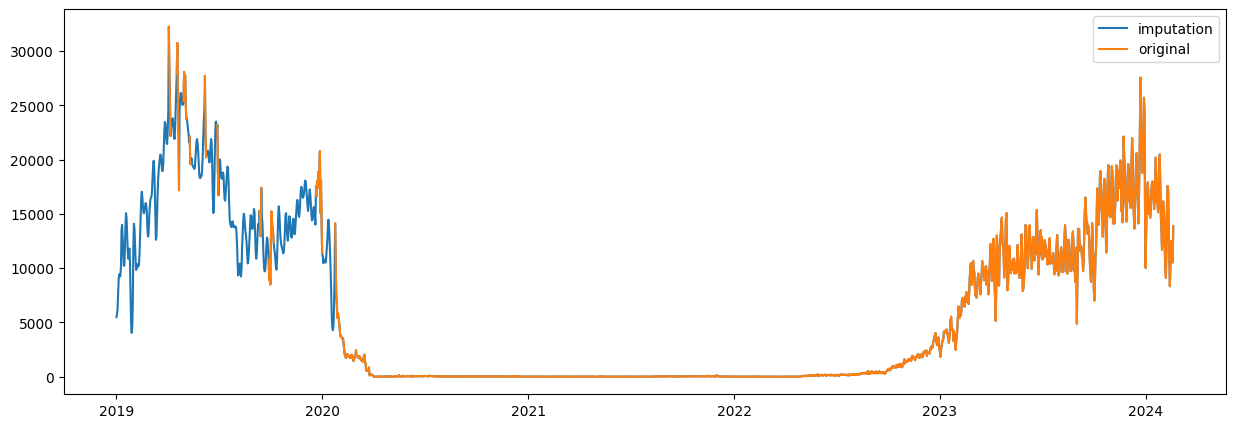

In [15]:
from matplotlib import pyplot as plt

# float to int
imputation_val = pd.DataFrame()
if use_standard_scaler:
    for i, column in enumerate(df_reindex_scaled.columns):
        if column not in ['date']:
            imputation_val[column] = scalers[column].inverse_transform(
                imputation.reshape(num_samples, num_features).reshape(-1, 1)).reshape(-1)
    imputation_val = imputation_val.astype('int')
else:
    imputation_val = pd.DataFrame(imputation.reshape(num_samples, num_features).astype('int'), columns=df.columns[1:])

imputation_val = pd.DataFrame({
    col: np.where(indicating_mask_and, imputation_val[col], df_reindex[col]) for col
    in
    df_reindex.columns
})
imputation_val.index = df_reindex.index

# revert data and draw
plt.figure(figsize=(15, 5))
plt.plot(imputation_val.index, imputation_val['global_airport_entry'], label='imputation')
plt.plot(df_reindex.index, df_reindex['global_airport_entry'], label='original')
plt.legend()
plt.show()

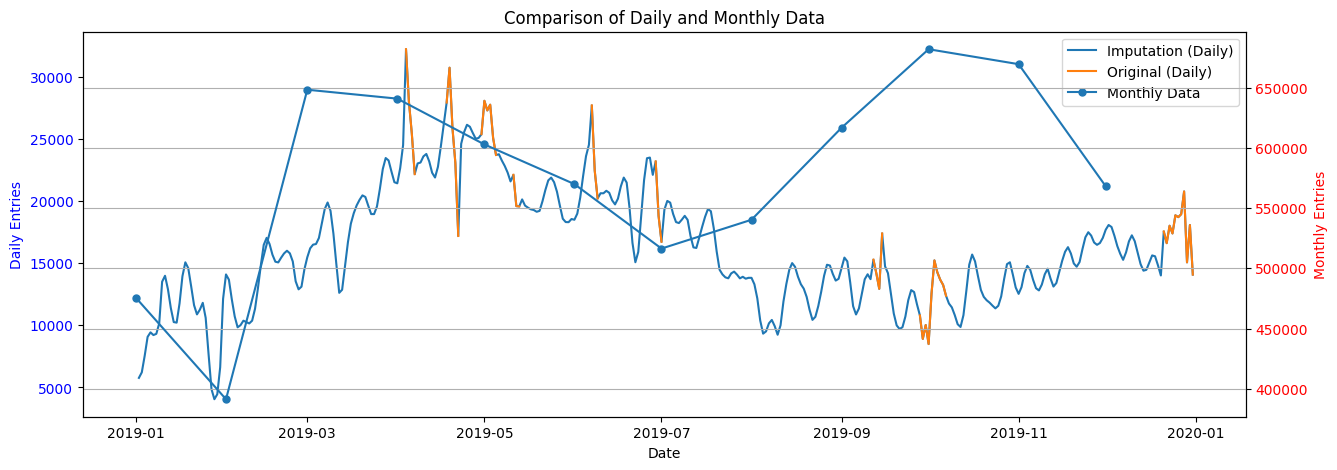

In [22]:
import matplotlib.pyplot as plt

# 日度数据的筛选
start_date = '2019-01-01'
end_date = '2020-01-01'
imputation_val_1 = imputation_val[(imputation_val.index > start_date) & (imputation_val.index < end_date)]
original_val_1 = df_reindex[(df_reindex.index > start_date) & (df_reindex.index < end_date)]

# 月度数据的查询和加载
query = f"SELECT date, global_entry FROM sh_visitors where date>='{start_date}' and date<='{end_date}'"
sh_df = pd.read_sql_query(query, engine, index_col='date', parse_dates=['date'])

# 创建图表
fig, ax1 = plt.subplots(figsize=(15, 5))

# 绘制日度数据
ax1.plot(imputation_val_1.index, imputation_val_1['global_airport_entry'], label='Imputation (Daily)')
ax1.plot(original_val_1.index, original_val_1['global_airport_entry'], label='Original (Daily)')
ax1.set_xlabel('Date')
ax1.set_ylabel('Daily Entries', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# 创建第二个y轴
ax2 = ax1.twinx()
ax2.plot(sh_df.index, sh_df['global_entry'], label='Monthly Data', linestyle='-', marker='o', markersize=5)
ax2.set_ylabel('Monthly Entries', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# 图例
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2)

# 显示图表
plt.title('Comparison of Daily and Monthly Data')
plt.grid(True)
plt.show()


# Move data into Database

In [ ]:
# if save_imputed_data is True:
# imputation_val.to_sql('hk_customs_daily_imputed', con=engine, if_exists='replace', index=True)